# TP1
## Question 1.1
Installer les packages


In [1]:
%pip install numpy pandas matplotlib scikit-learn mlxtend

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importer les librairies et lecture des fichiers .csv et .json

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json 
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import numpy as np

user = pd.read_csv('users_data.csv')
card = pd.read_csv('cards_data.csv')
transaction  = pd.read_csv('transactions_data.csv', dtype={'zip': str, 'mcc': str})

with open('mcc_codes.json', 'r') as f:
        mcc_code = json.load(f)

df_fraudes = pd.read_json("train_fraud_labels.json")
df_fraudes=df_fraudes.reset_index(names='trans_id')
df_fraudes['target'] = 'fraude=' + df_fraudes['target'].str.lower()

Faire des merges pour avoir une seule dataframe

In [ ]:
# Fusion des tableaux user et card selon le id user
user_card = pd.merge(user, card, how = 'left', left_on = 'id', right_on='client_id',suffixes=('_user','_card')).drop('client_id',axis = 1)

# Fusion des tableau card et transaction selon le id card
df = pd.merge(user_card, transaction, how = 'left', left_on = 'id_card', right_on='card_id',suffixes=('_user','_transaction')).drop(columns=['card_id','client_id'])
df.rename(columns={'id': 'id_transaction'}, inplace=True)

df=pd.merge(df, df_fraudes,left_on='id_transaction',right_on='trans_id')
df.rename(columns={'target': 'fraude'}, inplace=True)


In [4]:
df.head()

,id_user,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,...,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,trans_id,fraude
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$57.82,Swipe Transaction,50072.0,La Verne,CA,91750,5912,NaN,7483459,fraude=no
1,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$157.04,Swipe Transaction,61195.0,Mira Loma,CA,91752,5541,NaN,7487259,fraude=no
2,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$158.44,Swipe Transaction,46284.0,Monterey Park,CA,91754,5411,NaN,7491198,fraude=no
3,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$129.25,Swipe Transaction,61195.0,Mira Loma,CA,91752,5541,NaN,7522547,fraude=no
4,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$42.79,Swipe Transaction,20519.0,Monterey Park,CA,91755,5942,NaN,7522679,fraude=no


##  Question 1.2

Dans le tableau user, les variables les moins pertinants sont current_age, retirement_age, latitude, longitude. On n'a pas besoin de savoir l'âge du user si on peut le calculer à partir de la date de naissance. La latitude et la longitude ne sont pas nécessaire lorsqu'on possède l'adresse.

In [5]:
drop_col =["current_age","retirement_age","latitude", "longitude"]
df.drop(columns = drop_col,inplace=True)

## Question 1.3
les variables les moins pertinants sont current_age, retirement_age, latitude, longitude. On n'a pas besoin de savoir l'âge du user si on peut le calculer à partir de la date de naissance. La latitude et la longitude ne sont pas nécessaire lorsqu'on possède l'adresse
Enlever duplicate

In [6]:
df = df.drop_duplicates(subset=['id_user', 'id_card', 'id_transaction'])

Traitement données manquantes

In [7]:
df.isna().sum()

id_user                       0
birth_year                    0
birth_month                   0
gender                        0
address                       0
per_capita_income             0
yearly_income                 0
total_debt                    0
credit_score                  0
num_credit_cards              0
id_card                       0
card_brand                    0
card_type                     0
card_number                   0
expires                       0
cvv                           0
has_chip                      0
num_cards_issued              0
credit_limit                  0
acct_open_date                0
year_pin_last_changed         0
card_on_dark_web              0
id_transaction                0
date                          0
amount                        0
use_chip                      0
merchant_id                   0
merchant_city                 0
merchant_state            76418
zip                       80553
mcc                           0
errors  

In [8]:
df.isna().mean()*100

id_user                   0.000000
birth_year                0.000000
birth_month               0.000000
gender                    0.000000
address                   0.000000
per_capita_income         0.000000
yearly_income             0.000000
total_debt                0.000000
credit_score              0.000000
num_credit_cards          0.000000
id_card                   0.000000
card_brand                0.000000
card_type                 0.000000
card_number               0.000000
expires                   0.000000
cvv                       0.000000
has_chip                  0.000000
num_cards_issued          0.000000
credit_limit              0.000000
acct_open_date            0.000000
year_pin_last_changed     0.000000
card_on_dark_web          0.000000
id_transaction            0.000000
date                      0.000000
amount                    0.000000
use_chip                  0.000000
merchant_id               0.000000
merchant_city             0.000000
merchant_state      

In [9]:
df.dropna(subset='id_transaction', inplace=True)
df.fillna({'errors' : 'no error', }, inplace=True)

df.loc[df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'
df.loc[df['merchant_city'] == 'ONLINE', 'zip'] = 'ONLINE'
df.loc[(df['merchant_state'] != "ONLINE") & (df['merchant_state'].str.len() > 2), 'zip'] = "outside US"

In [10]:
df.isna().sum()

id_user                  0
birth_year               0
birth_month              0
gender                   0
address                  0
per_capita_income        0
yearly_income            0
total_debt               0
credit_score             0
num_credit_cards         0
id_card                  0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
id_transaction           0
date                     0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                      0
mcc                      0
errors                   0
trans_id                 0
fraude                   0
dtype: int64

Ajuster type de données

In [11]:

# Ajuster type de données de string à float
for col in ["per_capita_income", "yearly_income", "total_debt", "credit_limit","amount"]:
    df[col] = df[col].replace(r"[\$,]", "", regex=True).astype(float)

# Ajuster type de données de string à datetime
for col,formt in [("acct_open_date",'%m/%Y'),("expires",'%m/%Y'),("date",'%Y-%m-%d %H:%M:%S'),("year_pin_last_changed","%Y")]:
    df[col] = pd.to_datetime(df["acct_open_date"],errors='coerce',format =formt)

# Ajuster type de données de string à bool
for col in ["has_chip","card_on_dark_web"]:
    df[col] = df[col].str.lower().map({"yes": True, "no": False})

## Question 1.4
Pour birth_year, birth_month, il  est inutile d'avoir 2 colonnes pour la date de naissance. Dans le tableau transaction les variables merchant_city, merchant_state pourrait juste être une adresse.

## Question 1.5

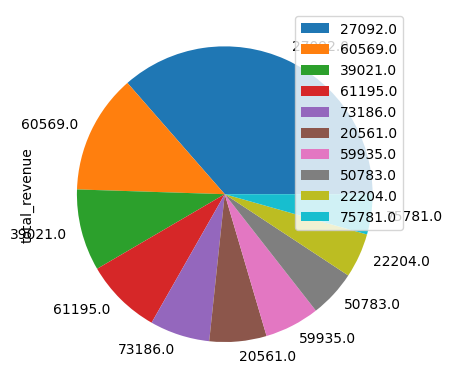

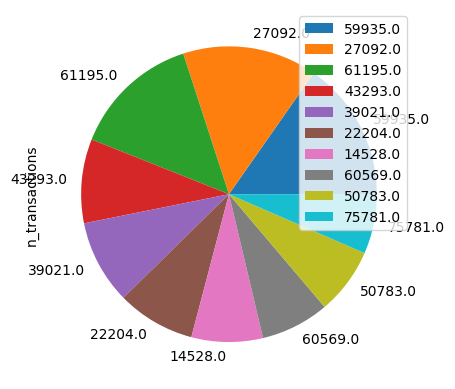

In [12]:
merchant = df.groupby("merchant_id").agg({
    "id_transaction": "count",
    "amount": "sum"
}).rename(columns={
    "id_transaction": "n_transactions",
    "amount": "total_revenue"
})

top_merchant_revenue = merchant.nlargest(10, "total_revenue")
top_merchant_count   = merchant.nlargest(10, "n_transactions")

top_merchant_revenue.plot(kind = 'pie',y = 'total_revenue')
top_merchant_count.plot(kind = 'pie',y = 'n_transactions')
plt.show()



## Question 1.6

In [13]:
df['mcc_description'] = df['mcc'].map(mcc_code).astype(str)


encoder = LabelEncoder()
df['card_type_encode'] = encoder.fit_transform(df["card_type"])

In [27]:
df['mcc_description']

0           Drug Stores and Pharmacies
1                     Service Stations
2         Grocery Stores, Supermarkets
3                     Service Stations
4                          Book Stores
                      ...             
702535                Service Stations
702536    Grocery Stores, Supermarkets
702537                     Book Stores
702538                 Wholesale Clubs
702539               Department Stores
Name: mcc_description, Length: 702540, dtype: object

## Question 2

In [15]:
q1 = df['amount'].quantile(0.25)
q2 = df['amount'].quantile(0.50)
q3 = df['amount'].quantile(0.75)

def categorize_amount_quartile ( x ) :
    if x <= q1 :
        return 'amount_low'
    elif x <= q2 :
        return  'amount_medium'
    elif x <= q3 :
        return 'amount_high'
    else :
        return 'amount_very_high'
    
df['amount_item'] = df['amount'].apply(categorize_amount_quartile)
df['credit_score_item'] = df['credit_score'].apply( 
    lambda x : 'credit_high' if x >= 700 else ('credit_medium' if
    x >= 500 else 'credit_low')
)
df['card_type_item'] = df['card_type'].apply( lambda x : f'card_ {x.lower ()}')
df['merchant_state_item'] = df['merchant_state'].apply( lambda x :f'state_ {x}')
df['mcc_item'] = df['mcc_description'].apply( lambda x : f'mcc_ {x.replace (" " , "_").lower ()}')

cols_to_unstack = ['mcc_item', 'card_type_item','merchant_state_item', 'amount_item', 'credit_score_item']
df_base = df[[ 'id_user', 'id_card']].copy()
df_base.rename( columns ={ 'id_user': 'client_id'} , inplace = True)
df_long = pd.melt(pd.concat([ df_base ,df[ cols_to_unstack ]] , axis =1) ,id_vars =[ 'client_id', 'id_card'] , value_vars = cols_to_unstack , value_name ='itemname') [[ 'client_id', 'id_card', 'itemname']]


In [16]:
df_long

,client_id,id_card,itemname
0,825,4524,mcc_ drug_stores_and_pharmacies
1,825,4524,mcc_ service_stations
2,825,4524,"mcc_ grocery_stores,_supermarkets"
3,825,4524,mcc_ service_stations
4,825,4524,mcc_ book_stores
...,...,...,...
3512695,185,5361,credit_high
3512696,185,5361,credit_high
3512697,185,5361,credit_high
3512698,185,5361,credit_high


In [ ]:
transactions = df_long.groupby(['client_id', 'id_card'])['itemname'].apply(list).tolist()

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = fpgrowth(df_encoded, min_support=.9, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)


In [25]:
#pd.set_option("display.max_rows", None)
# Display top rules sorted by lift
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_csv("association_rules.csv", index=False)

In [ ]:
#pd.reset_option("display.max_rows")

df_sorted = df.sort_values(by=['id_user', 'date'])
client_sequences = df_sorted.groupby('id_user').apply(
    lambda x: x[['date', 'mcc_description', 'amount', 'merchant_state', 'card_type']].to_dict(orient='records')
)

C:\Users\charl\AppData\Local\Temp\ipykernel_16628\2611442652.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  client_sequences = df_sorted.groupby('id_user').apply(
